In [125]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams.update({'font.size': 12})

FFT documentation:

https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.fft.fft.html#numpy.fft.fft

General background:

https://en.wikipedia.org/wiki/Discrete_Fourier_transform

https://en.wikipedia.org/wiki/Welch%27s_method

https://en.wikipedia.org/wiki/Periodogram


## Scipy Welch Example

Handy because it directly gives you the power spectral density of a signal in $V^2/Hz$!

I will use this to reverse-engineer what my conversion factors should be for my own FFT (which I can then also use on complex quadrature data, for example).

https://scipy.github.io/devdocs/generated/scipy.signal.welch.html

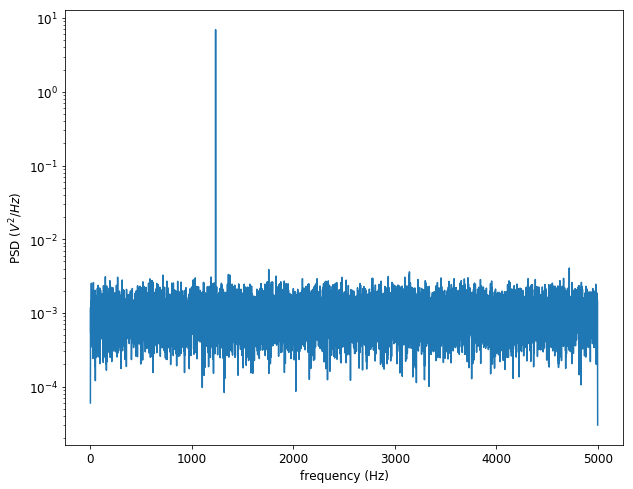

In [128]:
from scipy import signal
import matplotlib.pyplot as plt
np.random.seed(1234)

# fs = sampling frequency
fs = 10e3
# N = Number of samples
N = 1e5
# Amplitude of our sine wave
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

f, Pxx_den = scipy.signal.welch(x, fs, nperseg=2**15)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD ($V^2/Hz$)')
plt.show()

## Doing it myself and fudging the scaling factor until they match

Text(0, 0.5, 'Power Spectral Density (V$^2$/Hz)')

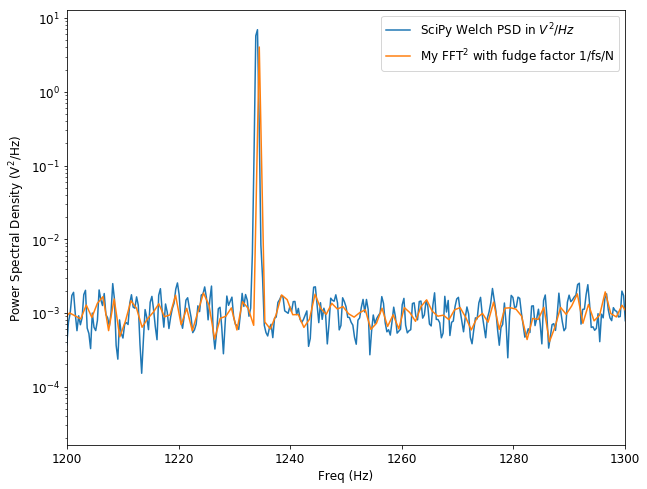

In [135]:
# Here, I will downsample smooth the FFT data, equivalent to "spectral plot"
# of power spectral density, in contrast to the Welch method that employs
# averaged periodograms 

# See wikipedia page on periodograms: https://en.wikipedia.org/wiki/Periodogram#Applications

def subsample_average(x, n):
    end =  n * int(len(x)/n)
    return np.mean(x[:end].reshape(-1, n), 1)

navg = 10
xf = np.fft.fftshift(np.fft.fft(x))
fr = np.fft.fftshift(np.fft.fftfreq(len(x), time[1]))

# Note that it's SUPER IMPORTANT to average the square magnitude!
# Noises add in quadrature, not amplitude...

test = np.abs(xf)**2
test2 = subsample_average(test,navg)
fr2 = subsample_average(fr,navg)

plt.plot(f,Pxx_den, label="SciPy Welch PSD in $V^2/Hz$")
# Factor of two here may be because I'm not doing rfft and 
# should add the negative frequency components
plt.plot(fr2,test2/fs/N*2, label="My FFT$^2$ with fudge factor 1/fs/N") 
plt.yscale('log')
plt.xlim((1200,1300))
plt.legend()
plt.xlabel("Freq (Hz)")
plt.ylabel("Power Spectral Density (V$^2$/Hz)")


Upshot: the conversion of FFT magntude squared to $V^2 / Hz$ is to divide by the sampling frequency `fs` AND by the number of samples `N`!

```
PSD = np.fft / fs / N**2
N = T / t_s  = T * f_s 

gives

PSD = np.fft / (fs**3 T**2)
```